In [1]:
import random
from collections import Counter, defaultdict
from pymongo import MongoClient
import pickle
import os
import json
from tqdm import tqdm_notebook, tqdm
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from utils import *
from sklearn.metrics.pairwise import cosine_similarity
import jieba
import re
import matplotlib.pyplot as plt
from datetime import timedelta

red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]

from sklearn.metrics import *
from rank_metrics import *

In [2]:
""" Two Functions for rating prediction and rank problem """
def evaluate_rating(preds, truths, metrics=['rmse', 'mae'], truct=[1, 5], around=True, **argv):
    """
        preds: [1.2,2.1,3.3,0,1,2]
        truths: [1,2,3,1,5,3]
        => remove missing values (rating predition is always condensed)
        => truct(preds) & around(preds)
        => rmse, mae
    """
    pts = [(p, t) for p, t in zip(preds, truths) if pd.isnull(p) == False and pd.isnull(t) == False]
    preds, truths = [p for p, t in pts], [t for p, t in pts]
    
    if truct is not None:
        vmin, vmax = truct[:2]
        preds = [vmax if v > vmax else vmin if v < vmin else v for v in preds]
    if around:
        preds = [np.around(v) for v in preds]
    
    if len(preds) == 0:
        return {"rmse": np.nan, "mae": np.nan}
    
    ans = {}
    for metric in metrics:
        if metric == "rmse":
            ans[metric] = np.sqrt(mean_squared_error(truths, preds))
        elif metric == "mae":
            ans[metric] = mean_absolute_error(truths, preds)
    return ans

def evaluate_rank(preds, truths, 
                   metrics=['ndcg', 'hit', 'hr', 'precision', 'recall', 'avg_gt'],
                   topk=[5, 10],
                   bfun=lambda t: 1.0 if t > 3 else 0.0,
                   metric_mode="full", **argv):
    """
        preds: [ 1.0, 1.2, 2.1, -1.0 ]
        truths: [ 1, 2, 1, 0]
        => remove missing value in preds (TODO: one option)
        => condensed (remove missing in truth) / full (treat the missing value as 0.0)
        => sorted by preds, generate list of truth-value 
        => (for hit, hr, precision, recall) bfun(truth)
        => ndcg@k, hit@k, ....
    """
    # filter when pred is nan.
    pts = [(p, t) for p, t in zip(preds, truths) if pd.isnull(p) == False]
    if metric_mode == "condensed":
        pts = [(p, t) for p, t in pts if pd.isnull(t) == False]
    elif metric_mode == "full":
        pts = [(p, t if not pd.isnull(t) else 0.0) for p, t in pts]
        
    pts = sorted(pts, key=lambda t: t[0], reverse=True)
    r = np.array([t for p, t in pts])
    bin_r = np.array([bfun(t) for p, t in pts])
    
    ans = {}
    for metric in metrics:
        for k in topk:
            m = '{}@{}'.format(metric, k)
            if metric == 'ndcg':
                # print (r, k)
                ans[m] = ndcg_at_k(r, k, method=1) if k != 'all' else ndcg_at_k(r, len(r), method=1)
            elif metric == "hit":
                ans[m] = float(sum(bin_r[:k]) > 0) if k != 'all' else float(sum(bin_r) > 0)
            elif metric == "hr" or metric == "precision": # hr=precision
                ans[m] = np.mean(bin_r[:k]) if k != 'all' else np.mean(bin_r)
            elif metric == "recall":
                ans[m] = float(np.sum(bin_r[:k]) / sum(bin_r)) if k != 'all' else 1.0
            elif metric == "avg_gt":
                ans[m] = np.mean(r[:k]) if k != "all" else np.mean(r)
    return ans


def evaluate_user(upreds, utruths, config, robust=False):
    """
        # upreds: {item: score} e.g. the model rank... 
        # utruths: {item: truth} e.g. user groundtruth... 
        upreds: [s1, s2, ...]
        utruths: [t1, t2, ...]
        => candidate=all: all the items predicted can be used to evaluate
        => candidate=test: only the items in ground-truth
        => candidate=sample: test + random.sampled negative results
        => evaluate_rating / evaluate_rank
        
        config:
            - candidate: [all, test, sample]
            - task: [rating, rank]
            - sample_total: (for candidate=sample)
            - metrics
            - topk
            - bfun
            - method: [full, condensed]
            - truct: (for rating) [vmin, vmax]
            - aound: (for rating) False/True
    """
    # -> upreds: dict (item, score), utest: dict (item, rating)
    preds, truths = [], []
    if config['candidate'] == "all":
        preds = upreds
        truths = utruths
    elif config['candidate'] == "test":
        for p, t in zip(upreds, utruths):
            if not pd.isnull(t):
                preds.append(p)
                truths.append(t)
    elif config['candidate'] == "sample":
        cands_idxs = []
        for i, (p, t) in enumerate(zip(upreds, utruths)):
            if not pd.isnull(t):
                preds.append(p)
                truths.append(t)
            else:
                cands_idxs.append(i)
        
        for idx in random.sample(cands_idxs, config['sample_total'] - len(truths)):
            preds.append( upreds[idx] )
            truths.append( utruths[idx] )

    if robust:
        print (preds, truths)
    assert len(preds) == len(truths) and len(truths) > 0
    if config['task'] == "rating":
        ans = evaluate_rating(preds, truths, **config)
    elif config['task'] == "rank":
        ans = evaluate_rank(preds, truths, **config)
    return ans

# Specific for user study data

In [3]:
%run "[Class] System Predictions (based on mongodb).ipynb" # SysPrediction
%run "[Class] User Peer Feedback (based on gen-0).ipynb" # UserFeedback, PeerAssessment

class UserStudyEvaluator:
    def __init__(self):
        self.user_hist_df = {}
        self.df_user = pd.DataFrame
        self.sys_predictions = SysPrediction
        
        self._prepare_data()
    
    def _prepare_data(self):
        # build user/hist/test
        self.user_hist_df = {}
        for tp in os.listdir("../../platform/RecServer/src/data/mix-data/"):
            if os.path.isdir(tp):
                self.user_hist_df[tp] = self._get_user_hist_test(tp)
        
        
        # build df_user: for _get_user_self_test
        self.df_user = pd.read_pickle("../data/user-study/fixbug/df_user.pkl")
        
        # add algorithms # BUG: phase2_recommend_top10 vs. phase2_recommend_top3
        client = MongoClient('mongodb://127.0.0.1:27017', username='', password="")
        ui_algos = {}
        for urec in client.Assess.user_phase2_recommend_top10.find():
            for trec in urec['rec_list']:
                ui_algos[(urec['user_id'], trec['item'])] = dict(trec['algorithms'])
        self.df_user['algorithms'] = list(map(lambda t: ui_algos[(t[0], t[1])] if (t[0], t[1]) in ui_algos else {},
                                              zip(self.df_user['user_id'], self.df_user['movie_id'])))
        
        
        # build peer: for _get_user_peer_test()
        peer_res = pd.read_pickle("../data/user-study/fixbug/df_peer.pkl")
        recs = []
        for (user_id, movie_id), tdf in peer_res.groupby(by=['user_id', 'movie_id']):
            recs.append((user_id, movie_id, np.nanmean(tdf['peer_preference'])))
        self.df_peer = pd.DataFrame.from_records(recs, columns=['user_id', 'movie_id', 'avg_peer_preference'])
        
        
        # build sys_predictions: for evaluate_for_user
        self.sys_predictions = SysPrediction(db="system_predictions_all")
    
    def _get_user_hist_test(self, user_id):
        if user_id in self.user_hist_df:
            return self.user_hist_df[user_id]
        
        tdf = pd.read_csv("../../platform/RecServer/src/data/mix-data/{}/test.csv".format(user_id), sep="\t")
        u_hist = tdf[tdf['user'] == user_id].copy()
        u_hist.reset_index(drop=True, inplace=True)
        u_hist.columns = ['user', 'item', 'rating']
        return u_hist
    
    def _get_user_self_test(self, user_id, model="all", gt_column="post_expected_preference"):
        """ 
            <user_id, model> -> [user, item, rating]
            model:
                - all
                - random/ pop/ userknn/ itemknn/ tfbiasedmf/ tfbpr
        """
        if model == "all":
            udf = self.df_user[self.df_user['user_id'] == user_id][['user_id', 'movie_id', gt_column]].copy()
        elif model[0] == "-":
            midx = self.df_user['algorithms'].map(lambda t: model[1:] not in t)
            udf = self.df_user[(self.df_user['user_id'] == user_id) & midx][['user_id', 'movie_id', gt_column]].copy()
        else:
            midx = self.df_user['algorithms'].map(lambda t: model in t)
            udf = self.df_user[(self.df_user['user_id'] == user_id) & midx][['user_id', 'movie_id', gt_column]].copy()
        udf.columns = ['user', 'item', 'rating']
        return udf
    
    def _get_user_peer_test(self, user_id, model="all", gt_column="avg_peer_preference"):
        """ 
            <user_id, model> -> [user, item, rating]
            model:
                - all
                - random/ pop/ userknn/ itemknn/ tfbiasedmf/ tfbpr
        """
        if model == "all":
            urecs = []
            for (u, i), tdf in self.df_peer[self.df_peer['user_id'] == user_id].groupby(['user_id', 'movie_id']):
                urecs.append((u, i, np.around(np.mean([float(t) for t in tdf[gt_column]]))))
            udf = pd.DataFrame.from_records(urecs, columns=['user', 'item', 'rating'])
        return udf
    
    def evaluate_for_user(self, user_id, model, config, test="hist/test", robust=True):
        """
            test: {"user": [], "item": [], "rating": []}
            candidates: "all", "test", "negsample"
        """
        # 1. for the user, build candidate set
        # 2. get system prediction for <user, item>, including Nan
        
        # 3. get user historical preference for <user, item>, including Nan
        # 4. get user self-preference for <user, item>, including Nan
        # 5. get user assess-preference for <user, item>, including Nan
        
        ucandidates = self.sys_predictions.get_user_candidates(user_id)
         
        # build different test set
        if test == "hist/test":
            test_df = self._get_user_hist_test(user_id)
        elif test.startswith("self"):
            m = test.split("/")[1]
            test_df = self._get_user_self_test(user_id, model=m)
            
            # fill to peer_df
            peer_df = self._get_user_peer_test(user_id)[['user', "item"]]
            test_df = peer_df.merge(test_df, on=['user', 'item'], how="left")
            # print (test_df.info())
            
        elif test.startswith("peer"):
            test_df = self._get_user_peer_test(user_id)
        else:
            raise ValueError("Undefined test: {}".format(test))
        ui_v = dict([(u, i), int(v)] for u, i, v in zip(test_df['user'], test_df['item'], test_df['rating']))
        
        upreds = [self.sys_predictions.get_prediction(user_id, iid, model) for iid in ucandidates]
        utest = [ui_v[(user_id, iid)] if (user_id, iid) in ui_v else np.nan for iid in ucandidates]
        return evaluate_user(upreds, utest, config, robust=robust)

In [4]:
model_names = {
    "tfbpr": "BPR",
    "bias": "Bias",
    "funksvd": "FunkSVD",
    "itemknn": "ItemKNN",
    "pop": "Pop",
    "random": "Random",
    "tfbiasedmf": "BiasedMF",
    "userknn": "UserKNN"
}
def plot_eval_rank(model_evals, metric, models=['random', "pop", "userknn", "itemknn", "tfbiasedmf", "tfbpr"], colors=[]):
    def yerr(X):
        n = len(X)
        X_mean = np.nanmean(X)
        X_std = np.std(X)
        X_se = X_std / np.sqrt(n)
        return X_se
    
    xs = np.arange(len(models))
    ys = []
    yerrs = []
    for tm in models:
        ys.append(model_evals[tm][metric]['mean'])
        yerrs.append(yerr([t for t in model_evals[tm][metric]['list'] if not pd.isnull(t)]))
    ys = np.array(ys)
    yerrs = np.array(yerrs)
    colors = np.array(colors)
    print (xs)
    plt.bar(xs[ys != np.nan], ys[ys != np.nan], color=colors[ys != np.nan])
    for tx, ty in zip(xs[ys != np.nan], ys[ys != np.nan]):
        plt.text(tx, ty, round(ty,3), ha="center", va="bottom")
    plt.errorbar(xs[ys != np.nan], ys[ys != np.nan], yerr=yerrs[ys != np.nan], fmt="o", markersize=1, elinewidth=1, capsize=3, color="k")
    # plt.xticks(xs, [model_names[tm] for tm in models], rotation=20)

In [5]:
us_evaluator = UserStudyEvaluator()
# user_ids = set(us_evaluator.df_user['user_id'])
user_ids = [
    "u_15810795617",
    "u_17801182378",
    "u_15313346392",
    "u_18222716322",
    "u_15071347094",
    "u_18712328742",
    "u_15900292575",
    "u_19920091165",
    "u_18221771895",
    "u_18811400801",
    "u_18811195178",
    "u_19801210262",
    "u_18993873008",
    "u_13701195791",
    "u_18800182977",
    "u_18801378212"
]

# Rank, Full

/home/luhongyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars
/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


9
[0 1 2 3 4 5]


/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


9
[0 1 2 3 4 5]


/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


9
[0 1 2 3 4 5]


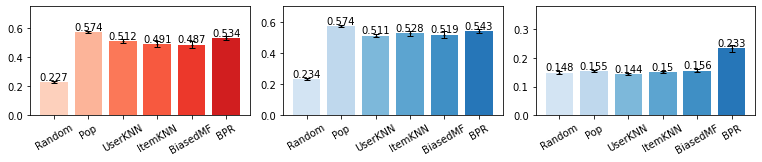

In [13]:
random.seed(2021)

# candidate=test vs. metric_mode=condensed: no.
# op1: candidate=all, metric_mode=full, [missing=0]
# op2: candidate=test, metric_mode=condensed [filter missing]
# op3: candidate=sample, metric_mode=full
config = {
    "task": "rank",
    "candidate": 'all', # all, test, sample
    "metrics": ['ndcg', 'hit', 'hr', 'precision', 'recall', 'avg_gt'],
    "topk": [3, 5, 10, 100, "all"],
    "bfun": lambda t: 1.0 if t > 3 else 0.0,
    "metric_mode": "full", # full, condensed
    "sample_total": 100
}

plot_metric = "ndcg@all"
self_model_colors = dict(zip(['random', "pop", "bias", "userknn", "itemknn", "tfbiasedmf", "tfbpr"], sns.color_palette("Reds", 10)[1:-2]))
model_colors = dict(zip(['random', "pop", "bias", "userknn", "itemknn", "tfbiasedmf", "tfbpr"], sns.color_palette("Blues", 10)[1:-2]))
plt.figure(figsize=(13, 2))

def eval_models(test):
    model_evals = {}
    for model in ['random', 'pop', 'userknn', 'itemknn', 'tfbiasedmf', 'tfbpr']:
        ures = {}
        for user in set(us_evaluator.df_user['user_id']) & set(us_evaluator.df_peer['user_id']):
            ures[user] = us_evaluator.evaluate_for_user(user, model, config=config, test=test, robust=False)

        metric_res = {}
        for user in ures:
            for metric in ures[user]:
                metric_res.setdefault(metric, {"list": []})
                metric_res[metric]['list'].append(ures[user][metric])
        for metric in metric_res:
            metric_res[metric]['mean'] = np.nanmean(metric_res[metric]['list'])
        model_evals[model] = metric_res
    return model_evals


def model_ranks_bootstrap(m_evals, metric, n=200, models=['random', "pop", "userknn", "itemknn", "tfbiasedmf", "tfbpr"]):
    ms = list(model_evals.keys())
    user_idxs = list(range(len(model_evals[ms[0]][metric]['list'])))
    iter_n = int(len(user_idxs) * 0.6)
    print (iter_n)
    ans = []
    for i in range(n):
        random.seed(i)
        t_u_idxs = list(user_idxs)
        random.shuffle(t_u_idxs)
        ans.append([np.mean(np.array(model_evals[m][metric]['list'])[t_u_idxs[:iter_n]]) for m in models])
    return ans

# -------- Hist/test --------- # 
model_evals = eval_models("hist/test")
hist_boot_ranks = model_ranks_bootstrap(model_evals, plot_metric)

plt.subplot(1, 3, 3)
models = ['random', "pop", "userknn", "itemknn", "tfbiasedmf", "tfbpr"]
plot_eval_rank(model_evals, plot_metric, models=models, colors=[model_colors[tm] for tm in models])
plt.ylim(0.0, 0.38)
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)

# -------- Self --------- # 
model_evals = eval_models("self/all")
self_boot_ranks = model_ranks_bootstrap(model_evals, plot_metric)

plt.subplot(1, 3, 1)
models = ['random', "pop", "userknn", "itemknn", "tfbiasedmf", "tfbpr"]
plot_eval_rank(model_evals, plot_metric, models=models, colors=[self_model_colors[tm] for tm in models])
plt.ylim(0.0, 0.75)
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)


# -------- Assessor --------- # 
model_evals = eval_models("peer/all")
peer_boot_ranks = model_ranks_bootstrap(model_evals, plot_metric)

plt.subplot(1, 3, 2)
models = ['random', "pop", "userknn", "itemknn", "tfbiasedmf", "tfbpr"]
plot_eval_rank(model_evals, plot_metric, models=models, colors=[model_colors[tm] for tm in models])
plt.ylim(0.0, 0.7)
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)

plt.subplots_adjust(wspace=0.15)
plt.savefig("figures/all_full_ndcgall.pdf", bbox_inches="tight")

In [14]:
from scipy import stats
tau_list = []
for i in range(len(self_boot_ranks)):
    tau_list.append(stats.kendalltau(self_boot_ranks[i], peer_boot_ranks[i])[0])
print (np.nanmean(tau_list))

0.7739130434782607


In [15]:
from scipy import stats
tau_list = []
for i in range(len(self_boot_ranks)):
    tau_list.append(stats.kendalltau(self_boot_ranks[i], hist_boot_ranks[i])[0])
print (np.nanmean(tau_list))

0.281159420289855


# Rank, Condensed

/home/luhongyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars
/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


9
[0 1 2 3 4 5]


/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


9
[0 1 2 3 4 5]


/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luhongyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


9
[0 1 2 3 4 5]


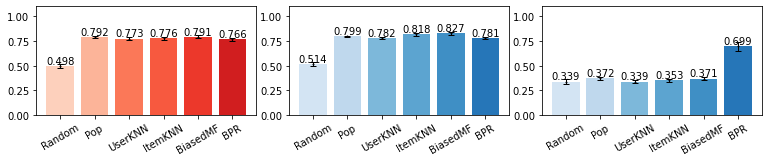

In [16]:
# candidate=test vs. metric_mode=condensed: no.
# op1: candidate=all, metric_mode=full, [missing=0]
# op2: candidate=test, metric_mode=condensed [filter missing]
# op3: candidate=sample, metric_mode=full
config = {
    "task": "rank",
    "candidate": 'sample', # all, test, sample
    "metrics": ['ndcg', 'hit', 'hr', 'precision', 'recall', 'avg_gt'],
    "topk": [3, 5, 10, 100, "all"],
    "bfun": lambda t: 1.0 if t > 3 else 0.0,
    "metric_mode": "full", # full, condensed
    "sample_total": 100
}

random.seed(2021)

plot_metric = "ndcg@all"
model_colors = dict(zip(['random', "pop", "bias", "userknn", "itemknn", "tfbiasedmf", "tfbpr"], sns.color_palette("Blues", 10)[1:-2]))
plt.figure(figsize=(13, 2))


def eval_models(test):
    model_evals = {}
    for model in ['random', 'pop', 'userknn', 'itemknn', 'tfbiasedmf', 'tfbpr']:
        ures = {}
        for user in set(us_evaluator.df_user['user_id']) & set(us_evaluator.df_peer['user_id']):
            ures[user] = us_evaluator.evaluate_for_user(user, model, config=config, test=test, robust=False)

        metric_res = {}
        for user in ures:
            for metric in ures[user]:
                metric_res.setdefault(metric, {"list": []})
                metric_res[metric]['list'].append(ures[user][metric])
        for metric in metric_res:
            metric_res[metric]['mean'] = np.nanmean(metric_res[metric]['list'])
        model_evals[model] = metric_res
    return model_evals


# -------- Hist/test --------- # 
model_evals = eval_models("hist/test")
hist_boot_ranks = model_ranks_bootstrap(model_evals, plot_metric)

plt.subplot(1, 3, 3)
models = ['random', "pop", "userknn", "itemknn", "tfbiasedmf", "tfbpr"]
plot_eval_rank(model_evals, plot_metric, models=models, colors=[model_colors[tm] for tm in models])
# plt.ylim(0.0, 0.38)
plt.ylim(0.0, 1.1)
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)

# -------- Self --------- # 
model_evals = eval_models("self/all")
self_boot_ranks = model_ranks_bootstrap(model_evals, plot_metric)

plt.subplot(1, 3, 1)
models = ['random', "pop", "userknn", "itemknn", "tfbiasedmf", "tfbpr"]
plot_eval_rank(model_evals, plot_metric, models=models, colors=[self_model_colors[tm] for tm in models])
plt.ylim(0.0, 1.1)
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)


# -------- Assessor --------- # 
model_evals = eval_models("peer/all")
peer_boot_ranks = model_ranks_bootstrap(model_evals, plot_metric)

plt.subplot(1, 3, 2)
models = ['random', "pop", "userknn", "itemknn", "tfbiasedmf", "tfbpr"]
plot_eval_rank(model_evals, plot_metric, models=models, colors=[model_colors[tm] for tm in models])
plt.ylim(0.0, 1.1)
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)

plt.subplots_adjust(wspace=0.15)
plt.savefig("figures/sample_full_ndcgall.pdf", bbox_inches="tight")

In [17]:
from scipy import stats
tau_list = []
for i in range(len(self_boot_ranks)):
    tau_list.append(stats.kendalltau(self_boot_ranks[i], peer_boot_ranks[i])[0])
print (np.nanmean(tau_list))

0.644927536231884


In [18]:
from scipy import stats
tau_list = []
for i in range(len(self_boot_ranks)):
    tau_list.append(stats.kendalltau(self_boot_ranks[i], hist_boot_ranks[i])[0])
print (np.nanmean(tau_list))

0.2028985507246377


# Rating Prediction

9
[0 1 2]
9
[0 1 2]
9
[0 1 2]


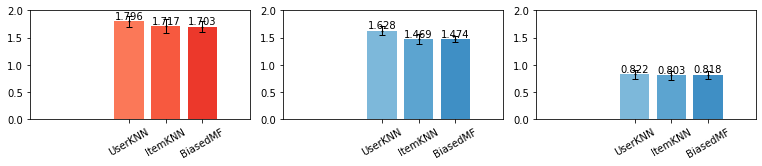

In [20]:
# candidate=test vs. metric_mode=condensed: no.
# op1: candidate=all, metric_mode=full, [missing=0]
# op2: candidate=test, metric_mode=condensed [filter missing]
# op3: candidate=sample, metric_mode=full
config = {
    "task": "rating",
    "candidate": 'test', # all, test, sample
    "metrics": ['rmse', 'mae'],
    "topk": [3, 5, 10, 100, "all"],
    "bfun": lambda t: 1.0 if t > 3 else 0.0,
    "metric_mode": "condensed", # full, condensed
    "sample_total": 100,
    "around": False,
    "truct": None
}

random.seed(2021)

plt.figure(figsize=(13, 2))
# -------- Hist/test --------- # 
test = "hist/test"
model_evals = {}
for model in ['bias', 'userknn', 'itemknn', 'tfbiasedmf']:
    ures = {}
    for user in set(us_evaluator.df_user['user_id']) & set(us_evaluator.df_peer['user_id']):
        ures[user] = us_evaluator.evaluate_for_user(user, model, config=config, test=test, robust=False)
    
    metric_res = {}
    for user in ures:
        for metric in ures[user]:
            metric_res.setdefault(metric, {"list": []})
            metric_res[metric]['list'].append(ures[user][metric])
    for metric in metric_res:
        metric_res[metric]['mean'] = np.nanmean(metric_res[metric]['list'])
    model_evals[model] = metric_res

hist_boot_ranks = model_ranks_bootstrap(model_evals, "rmse",  models=['bias', 'userknn', 'itemknn', 'tfbiasedmf'])

plt.subplot(1, 3, 3)
# model_colors = dict(zip(['bias', 'userknn', 'itemknn', 'tfbiasedmf'], sns.color_palette("pastel", 4)))
models = ['userknn', 'itemknn', 'tfbiasedmf']
plot_eval_rank(model_evals, 'rmse', models=models, colors=[model_colors[tm] for tm in models])
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)
plt.xlim(-2.7, 3.3)
plt.ylim(0.0, 2.0)

# -------- Self --------- # 
test = "self/all"
model_evals = {}
for model in ['bias', 'userknn', 'itemknn', 'tfbiasedmf']:
    ures = {}
    for user in set(us_evaluator.df_user['user_id']) & set(us_evaluator.df_peer['user_id']):
        ures[user] = us_evaluator.evaluate_for_user(user, model, config=config, test=test, robust=False)
    
    metric_res = {}
    for user in ures:
        for metric in ures[user]:
            metric_res.setdefault(metric, {"list": []})
            metric_res[metric]['list'].append(ures[user][metric])
    for metric in metric_res:
        metric_res[metric]['mean'] = np.nanmean(metric_res[metric]['list'])
    model_evals[model] = metric_res

self_boot_ranks = model_ranks_bootstrap(model_evals, "rmse", models=['bias', 'userknn', 'itemknn', 'tfbiasedmf'])

plt.subplot(1, 3, 1)
# model_colors = dict(zip(['bias', 'userknn', 'itemknn', 'tfbiasedmf'], sns.color_palette("pastel", 4)))
models = ['userknn', 'itemknn', 'tfbiasedmf']
plot_eval_rank(model_evals, 'rmse', models=models, colors=[self_model_colors[tm] for tm in models])
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)
plt.xlim(-2.7, 3.3)
plt.ylim(0.0, 2.0)

# -------- Assessor --------- # 
test = "peer/all"
model_evals = {}
for model in ['bias', 'userknn', 'itemknn', 'tfbiasedmf']:
    ures = {}
    for user in set(us_evaluator.df_user['user_id']) & set(us_evaluator.df_peer['user_id']):
        ures[user] = us_evaluator.evaluate_for_user(user, model, config=config, test=test, robust=False)
    
    metric_res = {}
    for user in ures:
        for metric in ures[user]:
            metric_res.setdefault(metric, {"list": []})
            metric_res[metric]['list'].append(ures[user][metric])
    for metric in metric_res:
        metric_res[metric]['mean'] = np.nanmean(metric_res[metric]['list'])
    model_evals[model] = metric_res

peer_boot_ranks = model_ranks_bootstrap(model_evals, "rmse", models=['bias', 'userknn', 'itemknn', 'tfbiasedmf'])

plt.subplot(1, 3, 2)
# model_colors = dict(zip(['bias', 'userknn', 'itemknn', 'tfbiasedmf'], sns.color_palette("pastel", 4)))
models = ['userknn', 'itemknn', 'tfbiasedmf']
plot_eval_rank(model_evals, 'rmse', models=models, colors=[model_colors[tm] for tm in models])
plt.xticks(range(len(models)), [model_names[t] for t in models], rotation=30)
plt.xlim(-2.7, 3.3)
plt.ylim(0.0, 2.0)

plt.subplots_adjust(wspace=0.15)
plt.savefig("figures/rating_rmse.pdf", bbox_inches="tight")

In [21]:
from scipy import stats
tau_list = []
for i in range(len(self_boot_ranks)):
    tau_list.append(stats.kendalltau(self_boot_ranks[i], peer_boot_ranks[i])[0])
print (np.nanmean(tau_list))

0.9021739130434783


In [22]:
from scipy import stats
tau_list = []
for i in range(len(self_boot_ranks)):
    tau_list.append(stats.kendalltau(self_boot_ranks[i], hist_boot_ranks[i])[0])
print (np.nanmean(tau_list))

0.49637681159420294
